# PupilTransmission tests

This notebook features integration tests of the `PupilTransmission` class. They are based on L-band imaging of a star and test that the measured flux in the simulated images varies in proportion to the throughput of the `PupilTransmission`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import scopesim as sim

In [3]:
sim.bug_report()

Python:
 3.9.7 (default, Sep 24 2021, 09:43:00) 
[GCC 10.3.0]

scopesim :  0.1.1
numpy :  1.21.2
scipy :  1.7.1
astropy :  4.3.1
matplotlib :  3.4.3
synphot :  1.0.1
requests :  2.25.1
bs4 :  4.9.3
yaml :  5.3.1

Operating system:  Linux
         Release:  5.14.0-1-amd64
         Version:  #1 SMP Debian 5.14.6-2 (2021-09-19)
         Machine:  x86_64


In [4]:
import os
PKGS_DIR = os.path.abspath(
    os.path.join(
        os.path.dirname("/home/oczoske/ELT_Development/irdb/METIS")))
sim.rc.__config__["!SIM.file.local_packages_path"] = PKGS_DIR

In [5]:
cmds = sim.UserCommands(use_instrument="METIS", set_modes=['img_lm'])

The pupil transmission is given by the parameter `!INST.pupil_transmission`, which defaults to 1. In the current implementation it needs to be set before building the optical train. Also, the optical train needs to be rebuilt every time that `!INST.pupil_transmission` is changed.

In [6]:
metis = sim.OpticalTrain(cmds)

In [7]:
metis.effects

element,name,class,included,z_orders
str27,str32,str22,str9,object
armazones,armazones_atmo_skycalc_ter_curve,SkycalcTERCurve,True,"[112, 512]"
armazones,armazones_atmo_dispersion,AtmosphericDispersion,False,[231]
armazones,armazones_atmo_default_ter_curve,AtmosphericTERCurve,False,"[111, 511]"
ELT,eso_combined_reflection,SurfaceList,True,"[20, 120, 520]"
ELT,scope_vibration,Vibration,False,"[244, 744]"
ELT,scope_surface_list,SurfaceList,False,"[20, 120, 520]"
METIS,metis_cfo_surfaces,SurfaceList,True,"[20, 120, 520]"
METIS,slit_wheel,SlitWheel,!OBS.slit,"[80, 280, 580]"
METIS,cold_stop,PupilTransmission,True,"[10, 110, 510]"


The cold stop is included, the default transmission is 1 as we can see by various means.

In [8]:
metis['cold_stop'].meta['transmission']

[1.0, 1.0]

In [9]:
from astropy import units as u

In [10]:
metis['cold_stop'].throughput(3.74 * u.um)

<Quantity 1.>

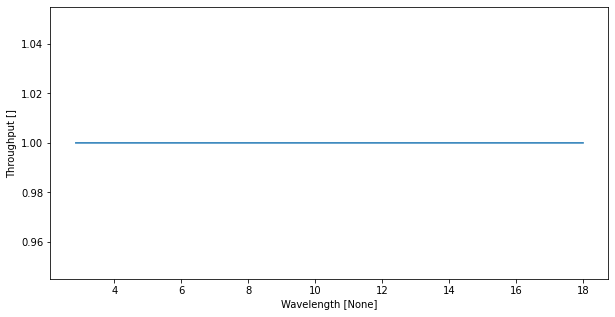

In [11]:
metis['cold_stop'].plot();

## Changing the pupil transmission

We now change the pupil transmission to 0.74 and check that the change is reflected properly.

In [12]:
cmds["!INST.pupil_transmission"] = 0.74

In [13]:
metis = sim.OpticalTrain(cmds)

In [14]:
metis['cold_stop'].meta['transmission']

[0.74, 0.74]

In [15]:
metis['cold_stop'].throughput(3.74 * u.um)

<Quantity 0.74>

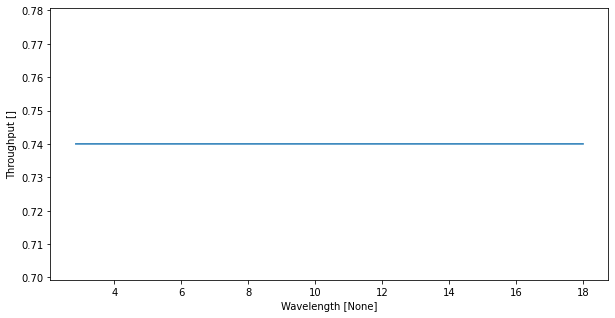

In [16]:
metis['cold_stop'].plot();

The pupil transmission can be changed in an existing `OpticalTrain` by doing

In [17]:
metis['cold_stop'].update_transmission(0.32)

In [18]:
metis['cold_stop'].throughput(3.74 * u.um)

<Quantity 0.32>

## Running simulations with varying pupil transmission

Create a `Source` object, we use a star.

In [19]:
spec = sim.source.source_templates.vega_spectrum(mag=12)
src = sim.Source(x=[0], y=[0], ref=[0], spectra=[spec])

In [20]:
from photutils import CircularAperture, aperture_photometry

In [21]:
images = []

In [22]:
pupil_transmission = [1., 0.75, 0.5, 0.25, 0.]

In [23]:
cmds["!OBS.dit"] = 10.
metis = sim.OpticalTrain(cmds)
metis['detector_linearity'].include = False

for ptrans in pupil_transmission:
    print(ptrans)
    metis['cold_stop'].update_transmission(ptrans)
    metis.observe(src, update=True)
    outhdul = metis.readout()[0]
    images.append(outhdul[1].data[981:1068, 981:1068])

1.0
Preparing 1 FieldOfViews
0.75
Preparing 1 FieldOfViews
0.5
Preparing 1 FieldOfViews
0.25
Preparing 1 FieldOfViews
0.0
Preparing 1 FieldOfViews


Look at one of the images:

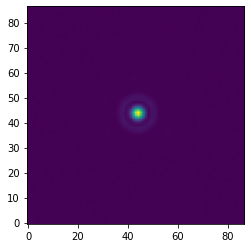

In [24]:
plt.imshow(images[3], origin='lower')

We perform aperture photometry on the images to check that pupil transmission is properly accounted for.

In [25]:
aperture = CircularAperture([42., 42.], r=10.)
bglevel = np.zeros(5)
bgnoise = np.zeros(5)
starsum = np.zeros(5)
starnoise = np.zeros(5)

In [26]:
for i, img in enumerate(images):
    bglevel[i] = np.mean(img[0:30, 0:30])
    bgnoise[i] = np.std(img[0:30, 0:30])
    
    phot_table = aperture_photometry(img - bglevel[i], aperture, error=np.ones_like(img) * bgnoise[i])
    starsum[i] = phot_table['aperture_sum'][0]
    starnoise[i] = phot_table['aperture_sum_err'][0]

In [27]:
from astropy.table import Table

In [28]:
table = Table([pupil_transmission, bglevel, bgnoise, starsum, starsum/starnoise],
             names=['Transmission', 'bg level', 'bg noise', 'Star counts', 'S/N'])
table['bg level'].format = '.0f'
table['bg noise'].format = '.1f'
table['Star counts'].format = '.1f'
table['S/N'].format = '.2f'

In [29]:
table.pprint()

Transmission bg level bg noise Star counts   S/N  
------------ -------- -------- ----------- -------
         1.0   728768    918.0  34303106.3 2108.29
        0.75   546537    753.6  25743688.9 1927.22
         0.5   364354    600.8  17170756.8 1612.45
        0.25   182176    433.0   8592456.3 1119.53
         0.0        1     12.0      -579.7   -2.72


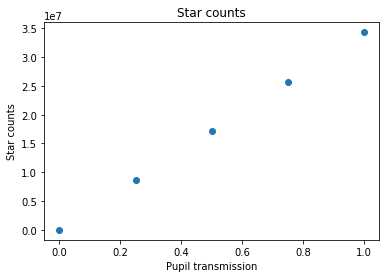

In [30]:
plt.plot(table['Transmission'], table['Star counts'], 'o')
plt.xlabel('Pupil transmission')
plt.ylabel("Star counts")
plt.title("Star counts");

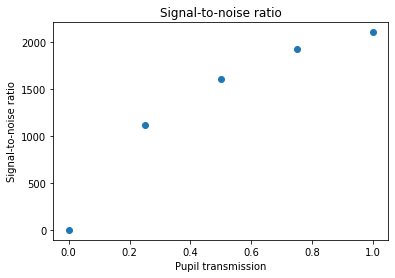

In [31]:
plt.plot(table['Transmission'], table['S/N'], 'o')
plt.xlabel('Pupil transmission')
plt.ylabel('Signal-to-noise ratio')
plt.title("Signal-to-noise ratio");